In [2]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
from leia import SentimentIntensityAnalyzer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy.lang.pt
from unidecode import unidecode
from string import punctuation

nltk.download('vader_lexicon')
nltk.download('rslp')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ynx/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package rslp to /home/ynx/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ynx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
dados1 = pd.read_csv("./PETR4.csv")
dados2 = pd.read_csv("./PETR4.csv")

In [4]:
analisador = SentimentIntensityAnalyzer()

def combinar_paragrafos(texto_lista):
    texto = ' '.join(texto_lista.strip("[]").replace("'", "").split(", "))
    return texto

def remover_maiusculas_e_pontuacao(texto):
    texto = texto.lower()
    texto = ''.join(char for char in texto if char not in punctuation)
    return texto

stopwords = spacy.lang.pt.stop_words.STOP_WORDS

def tratamento_texto(texto):
    texto_sem_acentos = unidecode(texto)
    palavras = texto_sem_acentos.split(' ')
    retorno = ''
    for p in palavras:
        if p not in stopwords:
            retorno += f"{p} "
    return retorno

def analisar_sentimento(texto):
    return analisador.polarity_scores(texto)

In [7]:
analisador.polarity_scores('Eu estou triste')

{'neg': 0.615, 'neu': 0.385, 'pos': 0.0, 'compound': -0.4939}

In [8]:
dados1['texto'] = dados1['texto'].apply(combinar_paragrafos)
dados1['sentimento'] = dados1['texto'].apply(analisar_sentimento)

dados2['texto'] = dados2['texto'].apply(remover_maiusculas_e_pontuacao)
dados2['sentimento'] = dados2['texto'].apply(analisar_sentimento)
dados2['texto'] = dados2['texto'].apply(tratamento_texto)

In [9]:
def plotar_analise(df):
    negativos = 0
    neutros = 0
    positivos = 0

    # Conte os sentimentos
    for analise in df.sentimento:
        if analise['compound'] >= 0.05:
            positivos += 1
        elif analise['compound'] <= -0.05:
            negativos += 1
        else:
            neutros += 1

    # Crie os rótulos e os valores para o gráfico de barras
    sentimentos = ['Negativo', 'Neutro', 'Positivo']
    quantidades = [negativos, neutros, positivos]

    print(quantidades)

    # Crie o gráfico de barras
    plt.bar(sentimentos, quantidades, color=['red', 'blue', 'green'])
    plt.xlabel('Sentimento')
    plt.ylabel('Quantidade')
    plt.title('Distribuição de Sentimentos')
plt.show()

[17, 2, 31]


,Unnamed: 0,titulo,data,hora,texto,sentimento
0,0,Investidores estrangeiros querem entender marc...,19.09.2023,15:34,O ministro da Fazenda Fernando Haddad disse ne...,"{'neg': 0.054, 'neu': 0.825, 'pos': 0.121, 'co..."
1,1,Petrobras contrata sonda de perfuração da Fore...,19.09.2023,14:37,RIO DE JANEIRO (Reuters) - A Petrobras (BVMF:P...,"{'neg': 0.019, 'neu': 0.895, 'pos': 0.086, 'co..."
2,2,Programa da Petrobras de crédito a fornecedore...,19.09.2023,12:35,Por Marta Nogueira RIO DE JANEIRO (Reuters) - ...,"{'neg': 0.039, 'neu': 0.886, 'pos': 0.074, 'co..."
3,3,Ibovespa tem variações modestas em clima de ex...,19.09.2023,11:10,Por Paula Arend Laier SÃO PAULO (Reuters) - O ...,"{'neg': 0.062, 'neu': 0.907, 'pos': 0.031, 'co..."
4,4,Ibovespa tem instabildiade antes de Fed e Copo...,19.09.2023,08:28,A alta do petróleo no exterior e o aumento aci...,"{'neg': 0.058, 'neu': 0.898, 'pos': 0.044, 'co..."


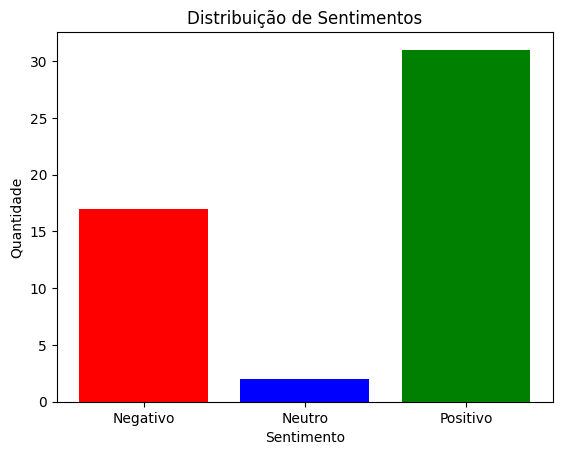

In [12]:
plotar_analise(dados1)
dados1.head()

[17, 1, 32]


,Unnamed: 0,titulo,data,hora,texto,sentimento
0,0,Investidores estrangeiros querem entender marc...,19.09.2023,15:34,ministro fazenda fernando haddad disse 3a feir...,"{'neg': 0.054, 'neu': 0.818, 'pos': 0.128, 'co..."
1,1,Petrobras contrata sonda de perfuração da Fore...,19.09.2023,14:37,rio janeiro reuters petrobras bvmfpetr4 assin...,"{'neg': 0.019, 'neu': 0.895, 'pos': 0.086, 'co..."
2,2,Programa da Petrobras de crédito a fornecedore...,19.09.2023,12:35,marta nogueira rio janeiro reuters programa p...,"{'neg': 0.04, 'neu': 0.885, 'pos': 0.075, 'com..."
3,3,Ibovespa tem variações modestas em clima de ex...,19.09.2023,11:10,paula arend laier sao paulo reuters ibovespa ...,"{'neg': 0.062, 'neu': 0.907, 'pos': 0.031, 'co..."
4,4,Ibovespa tem instabildiade antes de Fed e Copo...,19.09.2023,08:28,alta petroleo exterior aumento acima esperado ...,"{'neg': 0.061, 'neu': 0.895, 'pos': 0.045, 'co..."


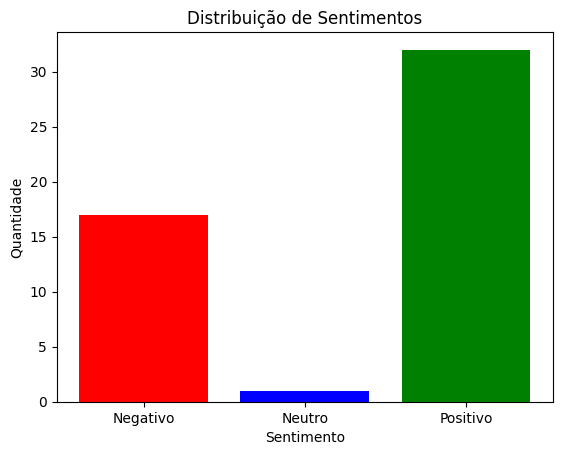

In [13]:
plotar_analise(dados2)
dados2.head()

,Unnamed: 0,titulo,data,hora,texto,sentimento
0,0,Investidores estrangeiros querem entender marc...,19.09.2023,15:34,ministro fazenda fernando haddad disse 3a feir...,"{'neg': 0.054, 'neu': 0.818, 'pos': 0.128, 'co..."
1,1,Petrobras contrata sonda de perfuração da Fore...,19.09.2023,14:37,rio janeiro reuters petrobras bvmfpetr4 assin...,"{'neg': 0.019, 'neu': 0.895, 'pos': 0.086, 'co..."
2,2,Programa da Petrobras de crédito a fornecedore...,19.09.2023,12:35,marta nogueira rio janeiro reuters programa p...,"{'neg': 0.04, 'neu': 0.885, 'pos': 0.075, 'com..."
3,3,Ibovespa tem variações modestas em clima de ex...,19.09.2023,11:10,paula arend laier sao paulo reuters ibovespa ...,"{'neg': 0.062, 'neu': 0.907, 'pos': 0.031, 'co..."
4,4,Ibovespa tem instabildiade antes de Fed e Copo...,19.09.2023,08:28,alta petroleo exterior aumento acima esperado ...,"{'neg': 0.061, 'neu': 0.895, 'pos': 0.045, 'co..."


In [12]:
token_espaco = tokenize.WhitespaceTokenizer()
frase_processada = list()
for noticia in dados.texto:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(noticia)
    stemmer = nltk.RSLPStemmer()
    for palavra in palavras_texto:
        nova_frase.append(stemmer.stem(palavra))
        frase_processada.append(' '.join(nova_frase))

    wordnet_lemmatizer = WordNetLemmatizer()

    for palavra in palavras_texto:
        nova_frase.append(wordnet_lemmatizer.lemmatize(palavra))
        frase_processada.append(' '.join(nova_frase))

In [16]:
def filtrar_palavras(texto, idioma, palavras_relevantes):
    if idioma == 'pt' or idioma == 'pt_BR':
        palavras = texto.split()
        palavras_filtradas = [word for word in palavras if word in palavras_relevantes]
        return ' '.join(palavras_filtradas)
    else:
        return ''

In [23]:
def pareto(texto, coluna_texto, quantidade):
    todas_palavras=' '.join([texto for texto in texto[coluna_texto]])
    frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
    df_frequencia = pd.DataFrame({'Palavra':list(frequencia.keys()),
    "Frequencia":list(frequencia.values())})
    plt.figure(figsize = (12,8))
    ax=sns.barplot(data = df_frequencia.nlargest(columns="Frequencia",  n=20), x="Palavra", y="Frequencia", color="gray")
    ax.set(ylabel="Contagem")
    plt.show()

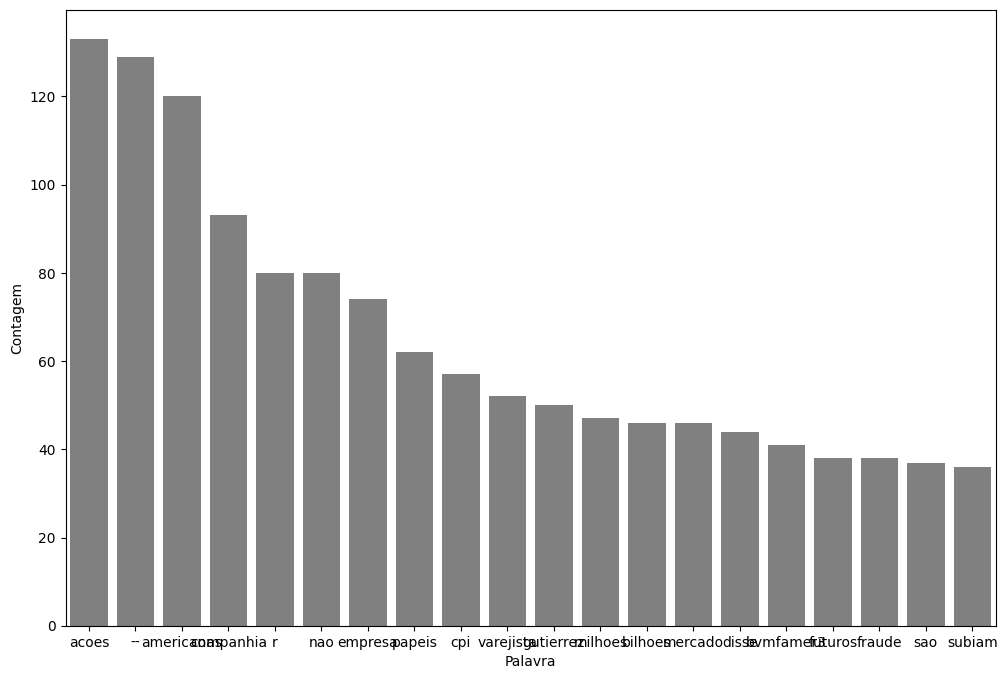

In [24]:
pareto(dados,"texto",10)

In [41]:
token_pontuacao = tokenize.WordPunctTokenizer()
pontuacao=list()
for ponto in punctuation:
    stopwords.add(ponto)

frase_processada=list()
for noticia in dados.texto:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(noticia)
    for palavra in palavras_texto:
        if palavra not in stopwords:
            nova_frase.append(palavra)
            frase_processada.append(" ".join(nova_frase))
            print(frase_processada)
    